# **WGAN-GP face generation - CelebA dataset**

## **Connect to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/google_drive')

## **Download dataset from Kaggle directly to GC virtual machine**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# file_path is the path where kaggle.json is present in the Google Drive

In [ ]:
%cd /content
%pwd
%ls

Place kaggle.json in the content folder 

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

## **WGAN-GP class**

In [ ]:
%tensorflow_version 1.x
from PIL import Image
import keras  
import matplotlib.pyplot as plt
import os
import pickle

def save_to_disk(txt_path, values):
    if os.path.isfile(txt_path):
        os.remove(txt_path)
    with open(txt_path, "wb") as fp:   
        pickle.dump(values, fp)
    print('Saved {}'.format(txt_path))
    return
def load_from_disk(txt_path):
    with open(txt_path, "rb") as f:
        values =  pickle.load(f)
    print("Loaded {}".format(txt_path))
    return values

def generateImages(generator, epoch, file_path, latent_space_size):
    rows = 3
    columns = 3
    noise = np.random.normal(0, 1, size=(rows*columns, latent_space_size))
    gen_imgs = generator.predict(noise)
    # rescale images
    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)
    # plot
    fig, axs = plt.subplots(rows, columns, figsize=(15,15))
    cnt = 0
    for i in range(rows):
        for j in range(columns):
            axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]))
            axs[i,j].axis('off')
            cnt += 1
    plots_path = os.path.join(file_path,'plots')
    os.makedirs(plots_path, exist_ok=True)
    fig.savefig(os.path.join(plots_path, "epoch{}.png".format(epoch)))
    plt.show()
    plt.close()


def create_conv_layer(input,convolution_type,filters,kernel_size,strides,padding,name,batch_norm=False,dropout=False,activation=True):
        convolution = getattr(keras.layers, convolution_type) # sets Conv2D or Conv2DTranspaose
        conv_layer = convolution(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding = padding,
            name = name
            )
        X = conv_layer(input)
        if batch_norm:
            X = BatchNormalization(momentum=0.9)(X)
        if activation:
            X = LeakyReLU(alpha=0.2)(X)
        return X

def set_trainable(model, value):
    model.trainable = value
    for layer in model.layers:
        layer.trainable = value


In [4]:
import numpy as np
import os
import keras
from keras.layers import Input,Conv2D,Conv2DTranspose,LeakyReLU,Flatten,Dense,BatchNormalization,Reshape,Activation, Multiply,Add, Lambda
from keras.models import load_model, Model
from keras.utils import plot_model
import keras.backend as K
from time import time

class RandomlyWeightedAverage(keras.layers.Layer):
    def __init__(self, batch_size,**kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
    def call(self,inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return inputs[0]*alpha + inputs[1]*(1-alpha)
    def get_config(self):
        config = {'batch_size': self.batch_size}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

class WassersteinGAN_GP(object):
    def __init__(self,
                 input_dims,
                 latent_space_size,
                 discriminator_filters,
                 discriminator_kernel_size,
                 discriminator_strides,
                 discriminator_padding,
                 discriminator_loss_weights,
                 generator_init_dense,
                 generator_batch_norm_momentum,
                 generator_filters,
                 generator_kernel_size,
                 generator_strides,
                 generator_padding,
                 optimizer,
                 batch_size
                 ):
        self.input_dims = input_dims
        self.latent_space_size = latent_space_size
        self.discriminator_filters = discriminator_filters
        self.discriminator_kernel_size = discriminator_kernel_size
        self.discriminator_strides = discriminator_strides
        self.discriminator_padding = discriminator_padding
        self.generator_init_dense = generator_init_dense
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_filters = generator_filters
        self.generator_kernel_size = generator_kernel_size
        self.generator_strides = generator_strides
        self.generator_padding = generator_padding
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.discriminator_loss_weights = discriminator_loss_weights
        self._create_model()
    def _create_model(self):
        self._create_discriminator()
        self._create_generator()
        # now that we have generator and discriminator we can make computational graph
        self._create_adversarial_graph()

    def _create_discriminator(self):
        discriminator_input = Input(shape=self.input_dims, name='dicriminator_input')
        X = discriminator_input
        for i in range(len(self.discriminator_filters)):
            X = create_conv_layer(X,
                                        "Conv2D",
                                        self.discriminator_filters[i],
                                        self.discriminator_kernel_size[i],
                                        self.discriminator_strides[i],
                                        self.discriminator_padding[i],
                                        "discriminator_conv"+str(i)
                                        )
        X = Flatten()(X)
        discriminator_output = Dense(units=1, activation=None)(X)
        self.discriminator = Model(inputs=discriminator_input,
                                   outputs=discriminator_output,
                                   name='Discriminator'
                                   )
    def _create_generator(self):
        generator_input = Input(shape=(self.latent_space_size,), name='generator_input')
        X = Dense(np.prod(self.generator_init_dense))(generator_input)
        X = BatchNormalization(momentum = self.generator_batch_norm_momentum)(X)    
        X = LeakyReLU(alpha=0.2)(X)
        X = Reshape(self.generator_init_dense)(X)
        for i in range(len(self.generator_filters)):
            is_not_last_layer = i < len(self.generator_filters)-1
            X = create_conv_layer(X,
                                  "Conv2DTranspose",
                                  self.generator_filters[i],
                                  self.generator_kernel_size[i],
                                  self.generator_strides[i],
                                  self.generator_padding[i],
                                  "generator_conv"+str(i),
                                  batch_norm=is_not_last_layer,
                                  activation=is_not_last_layer
                                  )
        generator_output = Activation('tanh')(X)
        self.generator = Model(inputs=generator_input,
                               outputs=generator_output,
                               name='Generator'
                               )
    def _create_adversarial_graph(self):
        #--------------------------------------------
        # discriminator (critic) computational graph
        #--------------------------------------------
        real_img = Input(shape=self.input_dims)
        latent_space = Input(shape=(self.latent_space_size,))
        fake_img = self.generator(latent_space)
        # interpolate real and fake images
        self.interpolated_img = RandomlyWeightedAverage(self.batch_size)([real_img, fake_img])
        # pass it through discriminator
        real_critic = self.discriminator(real_img)
        fake_critic = self.discriminator(fake_img)
        interpolated_critic = self.discriminator(self.interpolated_img)
        set_trainable(self.generator, False) # freeze weights for generator while training discriminator
        self.discriminator_model = Model(inputs=[real_img, latent_space],
                                         outputs=[real_critic, fake_critic, interpolated_critic],
                                         name='Discriminator_model'
                                         )
        self.discriminator_model.compile(
            loss=[self.Wasserstein_loss, self.Wasserstein_loss, self.GP_loss],
            optimizer=self.optimizer,
            loss_weights=self.discriminator_loss_weights
            )
        #--------------------------------------------
        # generator computational graph
        #--------------------------------------------
        gen_input = Input(shape=(self.latent_space_size,))
        gen_image = self.generator(gen_input)
        gen_output = self.discriminator(gen_image)
        set_trainable(self.generator,True)
        set_trainable(self.discriminator, False)
        self.generator_model = Model(inputs=gen_input, outputs=gen_output,name='Generator_model')
        self.generator_model.compile(
            loss=self.Wasserstein_loss,
            optimizer=self.optimizer
        )
        set_trainable(self.discriminator, True)
    def Wasserstein_loss(self, y_true, y_pred):
        return -K.mean(y_true*y_pred)
    def GP_loss(self,y_true,y_pred):
        gradients = K.gradients(y_pred, self.interpolated_img)[0]
        gradients_sqr = K.square(gradients)
        gradients_norm = K.sqrt(K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape))))
        return K.mean(K.square(1-gradients_norm))
    def _train_discriminator(self, images_train):
        real_labels = np.ones((self.batch_size,1), dtype='float32')
        fake_labels = -np.ones((self.batch_size,1), dtype='float32')
        dummy_labels = np.zeros((self.batch_size,1), dtype='float32') # this wont be in any calculation

        real_imgs = next(images_train)[0]
        if real_imgs.shape[0] != self.batch_size:
            real_imgs = next(images_train)[0]
        noise = np.random.normal(0,1,size=(self.batch_size,self.latent_space_size))

        d_loss = self.discriminator_model.train_on_batch(
            [real_imgs, noise],
            [real_labels, fake_labels, dummy_labels]
            )
        return d_loss
    def _train_generator(self):
        labels = np.ones((self.batch_size,1), dtype='float32')
        noise = np.random.normal(0,1,size=(self.batch_size,self.latent_space_size))
        g_loss = self.generator_model.train_on_batch(noise, labels)
        return g_loss
    def train(self,images_train,epochs,discriminator_iterations,steps_per_epoch,file_path,initial_epoch=0,continue_training=False):
        if continue_training:
            checkpoint_path = os.path.join(file_path,'trained')
            self.load_weights(checkpoint_path)
            g_losses = load_from_disk(os.path.join(checkpoint_path,'gLosses.txt'))
            d_losses = load_from_disk(os.path.join(checkpoint_path,'dLosses.txt'))
        else:
            d_losses = []
            g_losses = []
        epoch = initial_epoch
        steps = 0
        print('Training has started!')
        tic = time()
        while epoch < epochs:
            # train discriminator several times
            for i in range(discriminator_iterations):
                d_loss = self._train_discriminator(images_train)
                print("\r epoch {}: step {}/{}".format(epoch,steps,steps_per_epoch),end='')
                steps += 1
            # train generator
            g_loss = self._train_generator()
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            # if epoch ended
            if steps >= steps_per_epoch:
                toc = time() 
                print('')
                print(f"epoch {epoch} --->" +
                      f" D_losses: [R:{d_loss[0]:.2f}, F:{d_loss[1]:.2f}, GP:{d_loss[2]:.2f}]" + 
                      f" G_loss: {g_loss:.2f}" + 
                      f", elapsed time {(toc-tic)/60:.2f} min"
                )          
                epoch += 1
                generateImages(self.generator, epoch, file_path,self.latent_space_size)
            # checkpoint every 5 epochs
            if (epoch % 5 == 0) and (epoch != 0) and (steps >= steps_per_epoch): 
                checkpoint_path = os.path.join(file_path,'trained')
                os.makedirs(checkpoint_path, exist_ok=True)
                save_to_disk(os.path.join(checkpoint_path,'gLosses.txt'),g_losses)
                save_to_disk(os.path.join(checkpoint_path,'dLosses.txt'),d_losses)
                self.save_weights(checkpoint_path)
            if steps >= steps_per_epoch:
                steps=0
                tic = time()
        return d_losses, g_losses

    def save_weights(self, checkpoint_path):
        self.generator_model.save_weights(os.path.join(checkpoint_path,'generator_model_weights.h5'))
        self.discriminator_model.save_weights(os.path.join(checkpoint_path,'discriminator_model_weights.h5'))
        self.generator.save_weights(os.path.join(checkpoint_path,'generator_weights.h5'))
        self.discriminator.save_weights(os.path.join(checkpoint_path,'discriminator_weights.h5'))
        # save optimizer weights
        save_to_disk(os.path.join(checkpoint_path,'d_optimizer_weights.txt'),
                     self.discriminator_model.optimizer.get_weights()
                     )
        save_to_disk(os.path.join(checkpoint_path,'g_optimizer_weights.txt'),
                     self.generator_model.optimizer.get_weights()
                     )
        print('Weights are saved!')
    def load_weights(self, checkpoint_path):
        self.generator_model.load_weights(os.path.join(checkpoint_path,'generator_model_weights.h5'))
        self.discriminator_model.load_weights(os.path.join(checkpoint_path,'discriminator_model_weights.h5'))
        self.generator.load_weights(os.path.join(checkpoint_path,'generator_weights.h5'))
        self.discriminator.load_weights(os.path.join(checkpoint_path,'discriminator_weights.h5'))
        # load optimizer weights
        path = os.path.join(checkpoint_path,'d_optimizer_weights.txt')
        self.discriminator_model.optimizer.weights = load_from_disk(path)
        path = os.path.join(checkpoint_path,'g_optimizer_weights.txt')
        self.generator_model.optimizer.weights = load_from_disk(path)
        print('Pretrained weights are loaded!')

## **Create the model**

64x64 model

In [ ]:
from keras.optimizers import Adam
OPTIMIZER=Adam(lr=0.0002)
INPUT_DIMS = (64,64,3)
BATCH_SIZE = 64
LATENT_SPACE_SIZE=100
FILE_PATH = '/content/google_drive/My Drive/Colab Notebooks/WGAN_GP_faces'

WGAN_GP = WassersteinGAN_GP(
        input_dims=INPUT_DIMS,
        latent_space_size=LATENT_SPACE_SIZE,
        discriminator_filters=[64,128,256,512],
        discriminator_kernel_size=[5,5,5,5],
        discriminator_strides=[2,2,2,2],
        discriminator_padding=["same","same","same","same"],
        discriminator_loss_weights=[1,1,10],
        generator_init_dense=(4, 4, 512),
        generator_batch_norm_momentum=0.9,
        generator_filters=[256,128,64,3], 
        generator_kernel_size=[5,5,5,5],
        generator_strides=[2,2,2,2],
        generator_padding=["same","same","same","same"],
        optimizer=OPTIMIZER,
        batch_size=BATCH_SIZE
        )
print("Discriminator and generator summary:")
WGAN_GP.discriminator.summary()
WGAN_GP.generator.summary()

128x128 model


In [ ]:
from keras.optimizers import Adam
OPTIMIZER=Adam(lr=0.0002)
INPUT_DIMS = (128,128,3)
BATCH_SIZE = 64
LATENT_SPACE_SIZE=200
FILE_PATH = '/content/google_drive/My Drive/Colab Notebooks/WGAN_GP_faces'

WGAN_GP = WassersteinGAN_GP(
        input_dims=INPUT_DIMS,
        latent_space_size=LATENT_SPACE_SIZE,
        discriminator_filters=[64,128,256,512],
        discriminator_kernel_size=[3,3,3,3],
        discriminator_strides=[2,2,2,2],
        discriminator_padding=["same","same","same","same"],
        discriminator_loss_weights=[1,1,10],
        generator_init_dense=(8, 8, 512),
        generator_batch_norm_momentum=0.9,
        generator_filters=[256,128,64,3], 
        generator_kernel_size=[3,3,3,3],
        generator_strides=[2,2,2,2],
        generator_padding=["same","same","same","same"],
        optimizer=OPTIMIZER,
        batch_size=BATCH_SIZE
        )
print("Discriminator_model and generator_model summary:")
WGAN_GP.generator_model.summary()
WGAN_GP.generator.summary()

## **Train**


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

EPOCHS = 60
INITIAL_EPOCH = 30
DISCRIMINATOR_ITERATIONS = 5

# path to the FOLDER contatining images
DATA_PATH = os.path.join(os.getcwd(), "img_align_celeba") 
file_names = []
for file_name in os.listdir(os.path.join(DATA_PATH,"img_align_celeba")):
    file_names.append(file_name)
DATASET_SIZE = len(file_names)

# create image generator and data flow
data_generator = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)
data_flow = data_generator.flow_from_directory(
        DATA_PATH,
        target_size = INPUT_DIMS[:2],
        batch_size = BATCH_SIZE,
        shuffle = True,
        class_mode = 'input',
        subset = "training"
        )

# train the VAE with fit_generator
d_losses, g_losses = WGAN_GP.train(
        images_train=data_flow,
        epochs=EPOCHS,
        discriminator_iterations=DISCRIMINATOR_ITERATIONS,
        steps_per_epoch=DATASET_SIZE // BATCH_SIZE,
        file_path=FILE_PATH,
        initial_epoch=INITIAL_EPOCH,
        continue_training=True
        )

In [6]:
from statistics import mean
def average(data, frequency, start_avg_point):
    average_data = []
    if (len(data) > start_avg_point):
        round_num = -(len(str(frequency))-1)
        for i in range(0,round(len(data),round_num)-frequency,frequency):
            avg_data=mean(data[i:i+frequency])
            average_data.append(avg_data)
    return average_data

Loaded /content/google_drive/My Drive/Colab Notebooks/WGAN_GP_faces/trained/gLosses.txt
Loaded /content/google_drive/My Drive/Colab Notebooks/WGAN_GP_faces/trained/dLosses.txt


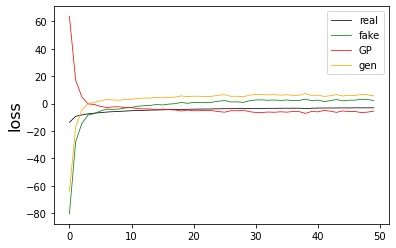

In [7]:
checkpoint_path = os.path.join(FILE_PATH, 'trained')
g_losses = load_from_disk(os.path.join(checkpoint_path,'gLosses.txt'))
d_losses = load_from_disk(os.path.join(checkpoint_path,'dLosses.txt'))
fig = plt.figure()
plt.plot(average([x[0] for x in d_losses],1000,0), color='black', linewidth=0.75)

plt.plot(average([x[1] for x in d_losses],1000,0), color='green', linewidth=0.75)
plt.plot(average([x[2] for x in d_losses],1000,0), color='red', linewidth=0.75)
plt.plot(average(g_losses,1000,0), color='orange', linewidth=0.75)
plt.legend(labels=['real','fake','GP','gen'])
plt.ylabel('loss', fontsize=16)

#plt.xlim(0, 2500)
plt.show()

## Generate faces


Loaded /content/google_drive/My Drive/Colab Notebooks/WGAN_GP_faces/trained/d_optimizer_weights.txt
Loaded /content/google_drive/My Drive/Colab Notebooks/WGAN_GP_faces/trained/g_optimizer_weights.txt
Pretrained weights are loaded!



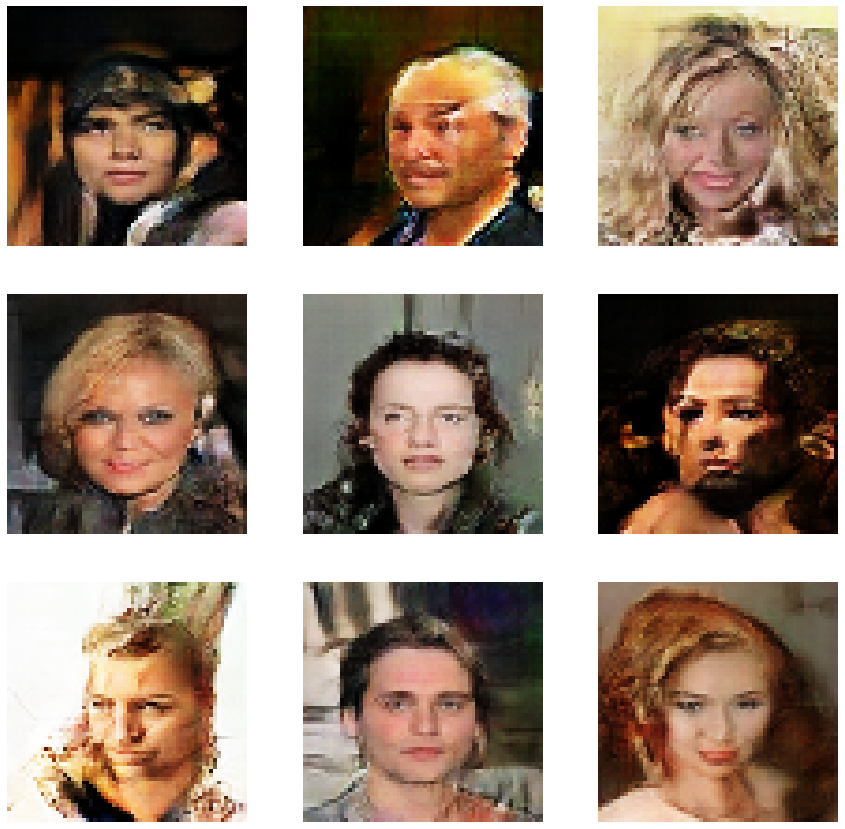

In [8]:
WGAN_GP.load_weights(os.path.join(FILE_PATH,'trained'))
generateImages(WGAN_GP.generator, epoch='Test', file_path=FILE_PATH, latent_space_size=LATENT_SPACE_SIZE)

## Vector arithmetic in latent space

Generate 100 faces and select images manualy

In [11]:
def generate(generator, num_of_images, latent_space_size):
    noise = np.random.normal(0, 1, size=(num_of_images, latent_space_size))
    gen_imgs = generator.predict(noise)
    # rescale images
    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)
    # plot
    for i in range(num_of_images):
        plt.figure()
        plt.imshow(gen_imgs[i, :,:,:])
        plt.title('image {}'.format(i))
    plt.show()
    return noise, gen_imgs

In [ ]:
WGAN_GP.load_weights(os.path.join(FILE_PATH,'trained'))
noise, gen_imgs = generate(WGAN_GP.generator, 100, LATENT_SPACE_SIZE)

Generate SMILING MAN from images of smiling women, neutral women and neutral man 

In [23]:
smiling_women_ind = [44,51,69]
neutral_women_ind = [63,19,78]
neutral_man_ind = [45,80,81]

In [24]:
def averageVectors(indicies, noise):
    return np.mean(noise[indicies,:], axis=0)

In [25]:
smiling_women = averageVectors(smiling_women_ind, noise)
neutral_women = averageVectors(neutral_women_ind, noise)
neutral_man = averageVectors(neutral_man_ind, noise)

In [31]:
smiling_man = smiling_women - neutral_women + neutral_man

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


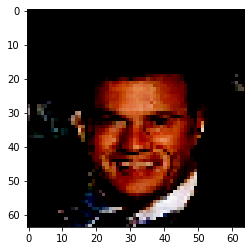

In [36]:
smiling_man_img = WGAN_GP.generator.predict(np.expand_dims(smiling_man,0))
plt.imshow(np.squeeze(smiling_man_img))

## Morph between faces

In [14]:
def morphBetweenImages(WGAN_GP, num_of_morphs, latent_space_size):
    # define alpha 
    alpha = np.linspace(0,1,num_of_morphs)
    # get latent spaces
    z1 = np.random.normal(0, 1, size=(1, latent_space_size))
    z2 = np.random.normal(0, 1, size=(1, latent_space_size))
    # morph and plot
    fig = plt.figure(figsize=(30,30))
    for i in range(num_of_morphs):
        z = z1*(1-alpha[i]) + z2*alpha[i]
        new_img = WGAN_GP.generator.predict(z)
        # rescale images
        new_img = 0.5 * (new_img + 1)
        new_img = np.clip(new_img, 0, 1)
        ax = fig.add_subplot(1, num_of_morphs, i+1)
        ax.imshow(new_img.squeeze())
        ax.axis('off')
        ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))
    return

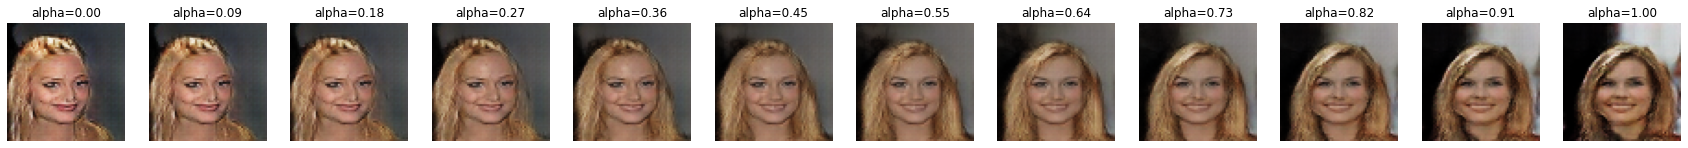

In [24]:
num_of_morphs = 12
morphBetweenImages(WGAN_GP, num_of_morphs, LATENT_SPACE_SIZE)